In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder


In [29]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_final.parquet")

In [30]:
#df_cct = df_cct.iloc[:int(len(df_cct)*0.8),:]

## I. OneHotEncoder

In [31]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [32]:
# Pour "Merchant State" : 

enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10) #on se limite aux 10 premières catégories

features_array = enc.fit_transform(df_cct[["Merchant State"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [33]:
# Pour "Merchant City" : 

enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10)

features_array = enc.fit_transform(df_cct[["Merchant City"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [34]:
# Pour "day_of_week" : 

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["day_of_week"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

## II. Sorting the columns and creating X1, y

In [35]:
selection = ['Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday','Is Fraud?']

In [36]:
estimators = ['Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']
df_selec = df_cct[selection]
#df_selec = df_selec[np.isfinite(df_selec).all(1)]
X1 = df_selec[estimators]
y = df_selec["Is Fraud?"]


In [37]:
a = 0.2

In [38]:
y_s = (1-a)*y + a/2

In [39]:
#X1.fillna(0, inplace=True)

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y, 
                                                    train_size = 0.70, test_size = 0.30, random_state = 1, stratify = y)

In [41]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

In [42]:
robust_transform = Pipeline(steps=['rb', RobustScaler()])

In [43]:
preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('std', RobustScaler(), ['Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income',
       'daily_amount', 'nb_daily_declines_card', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt',])
        ])

In [44]:
model = Pipeline(steps = [('pr', preprocessor), ('lr', LogisticRegression(class_weight = {1:0.85, 0:0.15}))])

In [45]:
model.fit(X_train, y_train)

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('pr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', RobustScaler(),
                                                  ['Card', 'Month', 'Day',
                                                   'Hours', 'Amount',
                                                   'delta_t_s',
                                                   'delta_t_s_card',
                                                   'amt/daily_income',
                                                   'daily_amount',
                                                   'nb_daily_declines_card',
                                                   'hr_nbt/last_30d_av_hr_nbt',
                                                   'last_3d_amt/nbt'])])),
                ('lr', LogisticRegression(class_weight={0: 0.15, 1: 0.85}))])

In [46]:
y_pred = model.predict(X_test)

In [47]:
y_pred_df = pd.DataFrame(y_pred)
# print(y_pred_df.describe())
# lpt.hist

In [48]:
model.score(X_test, y_test)

0.9986141466661747

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7307143
           1       0.11      0.02      0.03      8927

    accuracy                           1.00   7316070
   macro avg       0.56      0.51      0.52   7316070
weighted avg       1.00      1.00      1.00   7316070



In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

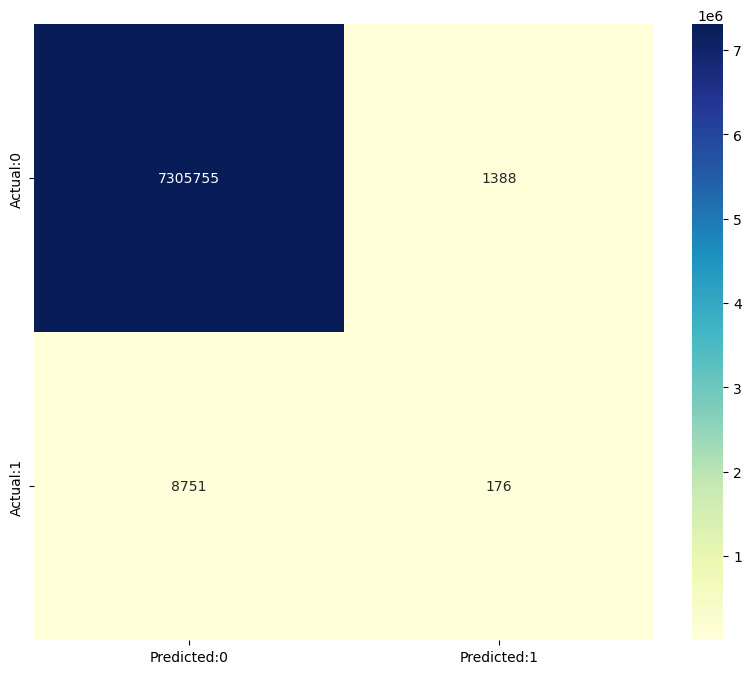

In [51]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [52]:
# print(model.steps[1][1].coef_)
# plt.bar(X1.columns, model.steps[1][1].coef_[0])
# plt.xticks(rotation = -90)
# plt.show()

df_coef = pd.DataFrame(model.steps[1][1].coef_,columns=X1.columns)
df_coef = df_coef.transpose()#.reset_index()
df_coef

,0
Card,0.342163
Month,0.120809
Day,0.021762
Hours,-0.473810
Amount,0.011541
delta_t_s,-0.154889
delta_t_s_card,-0.113279
amt/daily_income,0.000075
Retired,0.307750
daily_amount,0.065283


In [53]:
import plotly.express as px

In [54]:
px.bar(df_coef)
